In [1]:
import socket
import spynnaker8 as p
from pyNN.random import NumpyRNG, RandomDistribution
from pyNN.utility.plotting import Figure, Panel
import matplotlib.pyplot as plt
import os
import time
import numpy as np
import math
import cv2
import sys,tty,termios
import pdb
from numpy import genfromtxt


import sys
sys.path.insert(1, '../../miscelaneous')
from spinnorse_tools import fetch_files, plot_in_v_out, plot_spikes, plot_voltages
from stimulator import produce_data

In [2]:
duration = 12
r_ball = 3
l_px = 24
w_px = int(l_px*3/4)
mat, coor = produce_data(l_px, w_px, r_ball, duration)
# print(mat[3,4,:])

99.8 %

In [3]:
dt = 1           # (ms) simulation timestep

cell_params = {'tau_m': 20.0,
               'tau_syn_E': 5.0,
               'tau_syn_I': 5.0,
               'v_rest': -65.0,
               'v_reset': -65.0,
               'v_thresh': -50.0,
               'tau_refrac': 0.0, # 0.1 originally
               'cm': 1,
               'i_offset': 0.0
               }

w = 1.0
w_fovea = 0.5

In [4]:
nb_steps = duration*1000


#SpiNNaker Setup
delay = dt
node_id = p.setup(timestep=dt, min_delay=delay, max_delay=delay)     
p.set_number_of_neurons_per_core(p.IF_curr_exp, 100) #  100 neurons per core


celltype = p.IF_curr_exp

cells_l0 = []  
cells_l1 = []   
con_l0l1 = []  
con_move = []
w_x = np.zeros((2,l_px))
w_y = np.zeros((2,w_px))

idx = -1

m_labels = ["go_right", "go_left", "go_up", "go_down"]
colors = ["g", "r", "g", "r"]

move_neurons = []
for i in range(len(m_labels)):
    move_neurons.append(p.Population(1, celltype(**cell_params), label=m_labels[i]) )
    move_neurons[i].record(["v","spikes"])


for y in range(w_px):
        
    for x in range(l_px):
        
        idx += 1
        i_spikes = mat[y, x, :]
        i_indexes = np.where(i_spikes > 0)
        spike_trains = p.SpikeSourceArray(spike_times=(i_indexes))

        cur_label = "N_{:d}_{:d}".format(x, y)
        
        # Populations        
        cells_l0.append(p.Population(1,spike_trains))        
#         cells_l1.append(p.Population(1, celltype(**cell_params), label=cur_label))


        # Connectivity
        cell_conn = p.AllToAllConnector()
        cur_label = "i2l_{:d}_{:d}".format(x, y)         
#         con_l0l1.append({ 'i1l1': p.Projection(cells_l0[idx], cells_l1[idx], cell_conn,
#                                 receptor_type='excitatory',
#                                 synapse_type=p.StaticSynapse(weight=w, delay=delay))})
        
        # Move right (when stimulus on the left 'hemisphere')    
        if x < l_px/2:
            w_motor_x = w_fovea*(abs(x-l_px/2)/l_px )
            con_move.append({ 'l1lm': p.Projection(cells_l0[idx], move_neurons[0], cell_conn,
                                            receptor_type='excitatory',
                                            synapse_type=p.StaticSynapse(weight=w_motor_x, delay=delay))})
    
        # Move Left (when stimulus on the right 'hemisphere')
        if x > l_px/2:
            w_motor_x = w_fovea*(abs(x-l_px/2)/l_px )
            con_move.append({ 'l1lm': p.Projection(cells_l0[idx], move_neurons[1], cell_conn,
                                            receptor_type='excitatory',
                                            synapse_type=p.StaticSynapse(weight=w_motor_x, delay=delay))})
        
        # Move up (when stimulus on the bottom 'hemisphere')     
        if y < w_px/2: # higher pixel --> bottom of image
            w_motor_y = w_fovea*(abs(y-w_px/2)/w_px )
            con_move.append({ 'l1lm': p.Projection(cells_l0[idx], move_neurons[2], cell_conn,
                                            receptor_type='excitatory',
                                            synapse_type=p.StaticSynapse(weight=w_motor_y, delay=delay))})
        
        # Move down (when stimulus on the top 'hemisphere') 
        if y > w_px/2: # lower pixel --> top of image
            w_motor_y = w_fovea*(abs(y-w_px/2)/w_px )
            con_move.append({ 'l1lm': p.Projection(cells_l0[idx], move_neurons[3], cell_conn,
                                            receptor_type='excitatory',
                                            synapse_type=p.StaticSynapse(weight=w_motor_y, delay=delay))})
        
        
#         print("N_{:d}_{:d} --> ({:.3f},{:.3f})".format(x, y, w_motor_x, w_motor_y))
        
        # Setup recording 
        cells_l0[idx].record(["spikes"])
#         cells_l1[idx].record(["v","spikes"])

# print("\n\n\n\n\n\n\n\n")        
        
# Run simulation 
p.run(nb_steps)



        


2022-03-18 11:18:44 INFO: Read cfg files: /home/juan/spinstuff/lib/python3.6/site-packages/spinn_front_end_common/interface/spinnaker.cfg, /home/juan/spinstuff/lib/python3.6/site-packages/spynnaker/pyNN/spynnaker.cfg, /home/juan/.spynnaker.cfg
2022-03-18 11:18:44 INFO: Will search these locations for binaries: /home/juan/spinstuff/lib/python3.6/site-packages/spinn_front_end_common/common_model_binaries : /home/juan/spinstuff/lib/python3.6/site-packages/spynnaker/pyNN/model_binaries
2022-03-18 11:18:44 WARNING: /home/juan/spinstuff/experiments/closed_loop/reports has 23 old reports that have not been closed
2022-03-18 11:18:44 INFO: Setting time scale factor to 1.
2022-03-18 11:18:44 INFO: Setting machine time step to 1000 micro-seconds.


['/home/juan/spinstuff/lib/python3.6/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/juan/spinstuff/lib/python3.6/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/juan/.spynnaker.cfg']


2022-03-18 11:18:44 INFO: Starting execution process
2022-03-18 11:18:44 INFO: Simulating for 12000 1.0ms timesteps using a hardware timestep of 1000us
2022-03-18 11:18:45 INFO: Creating transceiver for 172.16.223.29
2022-03-18 11:18:45 INFO: Working out if machine is booted
2022-03-18 11:18:45 INFO: Found board with version [Version: SC&MP 3.4.1 at SpiNNaker:0:0:0 (built Thu Feb 11 15:36:44 2021)]
2022-03-18 11:18:45 INFO: Machine communication successful
2022-03-18 11:18:45 INFO: Detected a machine on IP address 172.16.223.29 which has 856 cores and 120.0 links
2022-03-18 11:18:45 INFO: Time 0:00:00.018353 taken by MachineGenerator
Preallocating resources for Extra Monitor support vertices
|0%                          50%                         100%|
2022-03-18 11:18:45 INFO: Time 0:00:00.137032 taken by PreAllocateResourcesForExtraMonitorSupport
2022-03-18 11:18:45 INFO: Time 0:00:00.003970 taken by NetworkSpecificationReport
Allocating virtual identifiers
|0%                      

2022-03-18 11:18:45 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo_atom=0, hi_atom=0, n_atoms=1) results in a core with a ReverseIPTagMulticastSourceMachineVertex which does not spike
2022-03-18 11:18:45 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo_atom=0, hi_atom=0, n_atoms=1) results in a core with a ReverseIPTagMulticastSourceMachineVertex which does not spike
2022-03-18 11:18:45 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo_atom=0, hi_atom=0, n_atoms=1) results in a core with a ReverseIPTagMulticastSourceMachineVertex which does not spike
=2022-03-18 11:18:45 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo_atom=0, hi_atom=0, n_atoms=1) results in a core with a ReverseIPTagMulticastSourceMachineVertex which does not spike
2022-03-18 11:18:45 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo_a

2022-03-18 11:18:45 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo_atom=0, hi_atom=0, n_atoms=1) results in a core with a ReverseIPTagMulticastSourceMachineVertex which does not spike
==2022-03-18 11:18:45 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo_atom=0, hi_atom=0, n_atoms=1) results in a core with a ReverseIPTagMulticastSourceMachineVertex which does not spike
2022-03-18 11:18:45 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo_atom=0, hi_atom=0, n_atoms=1) results in a core with a ReverseIPTagMulticastSourceMachineVertex which does not spike
=2022-03-18 11:18:45 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo_atom=0, hi_atom=0, n_atoms=1) results in a core with a ReverseIPTagMulticastSourceMachineVertex which does not spike
2022-03-18 11:18:45 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo

===2022-03-18 11:18:46 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo_atom=0, hi_atom=0, n_atoms=1) results in a core with a ReverseIPTagMulticastSourceMachineVertex which does not spike
2022-03-18 11:18:46 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo_atom=0, hi_atom=0, n_atoms=1) results in a core with a ReverseIPTagMulticastSourceMachineVertex which does not spike
2022-03-18 11:18:46 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo_atom=0, hi_atom=0, n_atoms=1) results in a core with a ReverseIPTagMulticastSourceMachineVertex which does not spike
2022-03-18 11:18:46 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo_atom=0, hi_atom=0, n_atoms=1) results in a core with a ReverseIPTagMulticastSourceMachineVertex which does not spike
===2022-03-18 11:18:46 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice

2022-03-18 11:18:46 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo_atom=0, hi_atom=0, n_atoms=1) results in a core with a ReverseIPTagMulticastSourceMachineVertex which does not spike
2022-03-18 11:18:46 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo_atom=0, hi_atom=0, n_atoms=1) results in a core with a ReverseIPTagMulticastSourceMachineVertex which does not spike
=2022-03-18 11:18:46 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo_atom=0, hi_atom=0, n_atoms=1) results in a core with a ReverseIPTagMulticastSourceMachineVertex which does not spike
2022-03-18 11:18:46 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo_atom=0, hi_atom=0, n_atoms=1) results in a core with a ReverseIPTagMulticastSourceMachineVertex which does not spike
2022-03-18 11:18:46 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo_a

=
Partitioning graph edges
|0%                          50%                         100%|
2022-03-18 11:18:46 INFO: Time 0:00:01.161234 taken by SpYNNakerSplitterPartitioner
Inserting extra monitors into graphs
|0%                          50%                         100%|
2022-03-18 11:18:46 INFO: Time 0:00:00.022789 taken by InsertExtraMonitorVerticesToGraphs
Generating partitioner report
|0%                          50%                         100%|
2022-03-18 11:18:46 INFO: Time 0:00:00.074762 taken by PartitionerReport
Getting number of keys required by each edge using application graph
|0%                          50%                         100%|
2022-03-18 11:18:46 INFO: Time 0:00:00.066506 taken by EdgeToNKeysMapper
2022-03-18 11:18:46 INFO: The time scale factor could be reduced to 0
2022-03-18 11:18:46 INFO: Time 0:00:00.001201 taken by LocalTDMABuilder
Placing graph vertices via spreading over an entire machine
|0%                          50%                         100%|


Running bitfield generation on chip
|0%                          50%                         100%|


2022-03-18 11:19:10 INFO: Time 0:00:03.401868 taken by OnChipBitFieldGenerator
Finalising Retrieved Connections
|0%                          50%                         100%|
2022-03-18 11:19:11 INFO: Time 0:00:00.126292 taken by FinishConnectionHolders
Reading Routing Tables from Machine
|0%                          50%                         100%|
2022-03-18 11:19:11 INFO: Time 0:00:00.702987 taken by ReadRoutingTablesFromMachine
Generating compressed router table report
|0%                          50%                         100%|
2022-03-18 11:19:11 INFO: Time 0:00:00.040573 taken by compressedRoutingTableReports
Generating comparison of router table report
|0%                          50%                         100%|
2022-03-18 11:19:11 INFO: Time 0:00:00.019644 taken by comparisonOfRoutingTablesReport
Generating Routing summary report
|0%                          50%           

12000.0

In [5]:

i_indexes = []
o_indexes = []
v_arrays = []
for neuron_nb in range(0,w_px*l_px,1):
    
    in_spikes = cells_l0[neuron_nb].get_data("spikes")
#     l1_spikes = cells_l1[neuron_nb].get_data("spikes")
#     l1_voltage = cells_l1[neuron_nb].get_data("v")

    i_indexes.append(np.asarray(in_spikes.segments[0].spiketrains[0]))   
#     o_indexes.append(np.asarray(l1_spikes.segments[0].spiketrains[0]))
#     v_arrays.append(np.array(l1_voltage.segments[0].filter(name="v")[0]).reshape(-1))



m_indexes = []
m_v_arrays = []
for i in range(len(m_labels)):    
    spikes = move_neurons[i].get_data("spikes")
    voltage = move_neurons[i].get_data("v")
    m_indexes.append(np.asarray(spikes.segments[0].spiketrains[0]))
    m_v_arrays.append(np.array(voltage.segments[0].filter(name="v")[0]).reshape(-1))


Getting spikes for SpikeSourceArrayVertex_1
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_2
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_3
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_4
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_5
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_6
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_7
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_8
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_9
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVe

Getting spikes for SpikeSourceArrayVertex_50
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_51
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_52
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_53
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_54
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_55
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_56
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_57
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_58
|0%                          50%                         100%|
Getting spikes for SpikeSour

Getting spikes for SpikeSourceArrayVertex_98
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_99
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_100
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_101
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_102
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_103
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_104
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_105
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_106
|0%                          50%                         100%|
Getting spikes for Sp

Getting spikes for SpikeSourceArrayVertex_146
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_147
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_148
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_149
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_150
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_151
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_152
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_153
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_154
|0%                          50%                         100%|
Getting spikes for 

Getting spikes for SpikeSourceArrayVertex_194
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_195
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_196
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_197
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_198
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_199
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_200
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_201
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_202
|0%                          50%                         100%|
Getting spikes for 

Getting spikes for SpikeSourceArrayVertex_242
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_243
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_244
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_245
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_246
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_247
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_248
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_249
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_250
|0%                          50%                         100%|
Getting spikes for 

Getting spikes for SpikeSourceArrayVertex_290
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_291
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_292
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_293
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_294
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_295
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_296
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_297
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_298
|0%                          50%                         100%|
Getting spikes for 

Getting spikes for SpikeSourceArrayVertex_338
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_339
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_340
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_341
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_342
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_343
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_344
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_345
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_346
|0%                          50%                         100%|
Getting spikes for 

Getting spikes for SpikeSourceArrayVertex_386
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_387
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_388
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_389
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_390
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_391
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_392
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_393
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_394
|0%                          50%                         100%|
Getting spikes for 

Getting v for go_right
|0%                          50%                         100%|
Getting spikes for go_left
|0%                          50%                         100%|
Getting v for go_left
|0%                          50%                         100%|
Getting spikes for go_up
|0%                          50%                         100%|
Getting v for go_up
|0%                          50%                         100%|
Getting spikes for go_down
|0%                          50%                         100%|
Getting v for go_down
|0%                          50%                         100%|


In [6]:

p.end()

2022-03-18 11:19:53 WARNING: No SDP packets were received by SpikeSourceArrayVertex_218:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 11:19:53 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_218:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 11:19:53 WARNING: No SDP packets were received by SpikeSourceArrayVertex_217:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 11:19:53 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_217:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 11:19:53 WARNING: No SDP packets were received by SpikeSourceArrayVertex_240:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 11:19:53 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_240:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 11:19:53 WARNING: No

2022-03-18 11:19:53 WARNING: No SDP packets were received by SpikeSourceArrayVertex_20:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 11:19:53 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_20:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 11:19:53 WARNING: No SDP packets were received by SpikeSourceArrayVertex_21:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 11:19:53 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_21:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 11:19:53 WARNING: No SDP packets were received by SpikeSourceArrayVertex_22:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 11:19:53 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_22:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 11:19:53 WARNING: No SDP p

2022-03-18 11:19:53 WARNING: No SDP packets were received by SpikeSourceArrayVertex_57:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 11:19:53 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_57:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 11:19:53 WARNING: No SDP packets were received by SpikeSourceArrayVertex_58:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 11:19:53 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_58:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 11:19:53 WARNING: No SDP packets were received by SpikeSourceArrayVertex_59:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 11:19:53 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_59:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 11:19:53 WARNING: No SDP p

2022-03-18 11:19:53 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_119:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 11:19:53 WARNING: No SDP packets were received by SpikeSourceArrayVertex_120:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 11:19:53 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_120:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 11:19:53 WARNING: No SDP packets were received by SpikeSourceArrayVertex_121:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 11:19:53 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_121:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 11:19:53 WARNING: No SDP packets were received by SpikeSourceArrayVertex_141:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 11:19:53 WARNING: No

2022-03-18 11:19:53 WARNING: No SDP packets were received by SpikeSourceArrayVertex_267:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 11:19:53 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_267:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 11:19:53 WARNING: No SDP packets were received by SpikeSourceArrayVertex_288:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 11:19:53 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_288:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 11:19:53 WARNING: No SDP packets were received by SpikeSourceArrayVertex_289:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 11:19:53 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_289:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 11:19:53 WARNING: No

2022-03-18 11:19:53 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_365:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 11:19:53 WARNING: No SDP packets were received by SpikeSourceArrayVertex_374:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 11:19:53 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_374:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 11:19:53 WARNING: No SDP packets were received by SpikeSourceArrayVertex_375:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 11:19:53 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_375:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 11:19:53 WARNING: No SDP packets were received by SpikeSourceArrayVertex_376:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 11:19:53 WARNING: No

2022-03-18 11:19:53 WARNING: No SDP packets were received by SpikeSourceArrayVertex_410:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 11:19:53 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_410:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 11:19:53 WARNING: No SDP packets were received by SpikeSourceArrayVertex_411:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 11:19:53 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_411:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 11:19:53 WARNING: No SDP packets were received by SpikeSourceArrayVertex_412:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 11:19:53 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_412:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 11:19:53 WARNING: No

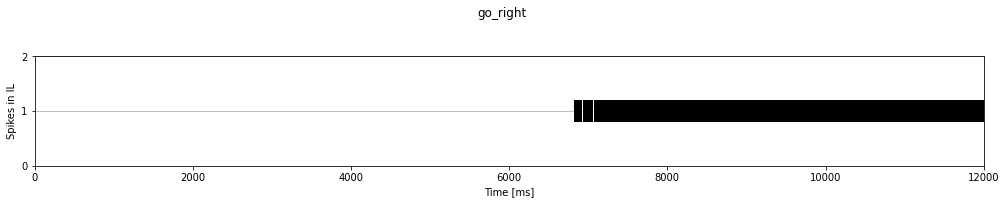

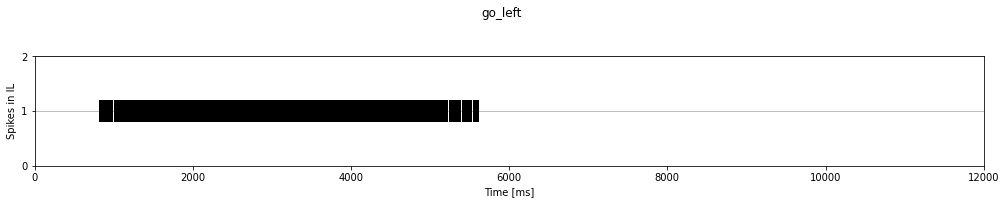

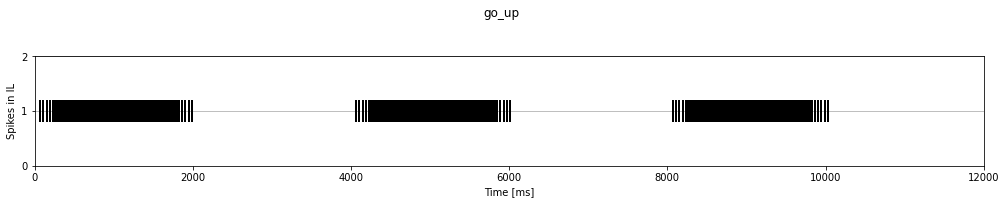

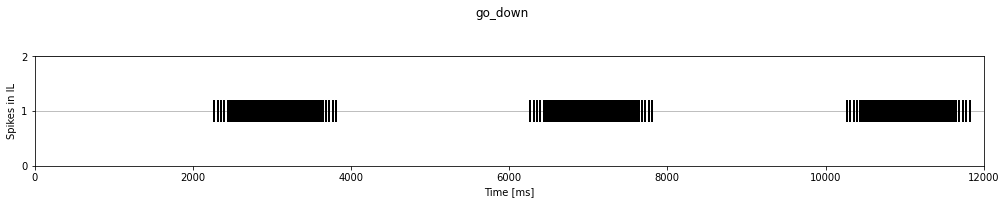

In [7]:

xlim = nb_steps       
for i in range(4):
    plot_spikes(m_indexes[i:i+1], m_labels[i], nb_steps)
# for i in range(4):
#     plot_voltages(m_v_arrays[i:i+1], "Go " + labels[i], nb_steps)

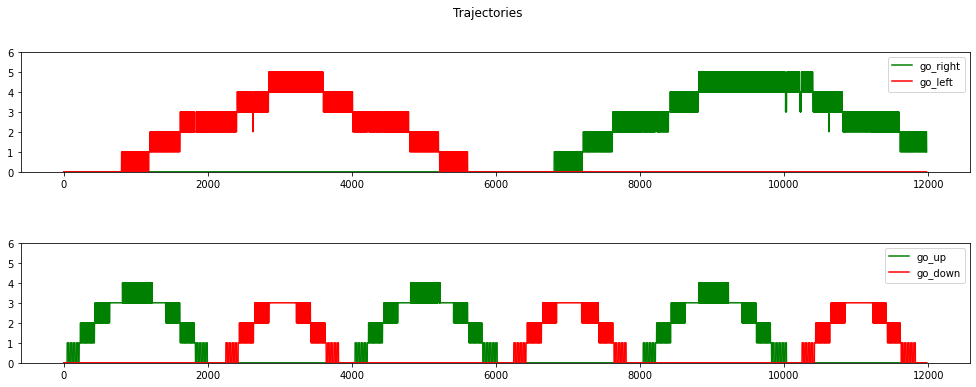

In [8]:

win_size = 20

fig, axs = plt.subplots(2, figsize=(15,6))
fig.tight_layout(pad=5.0)
fig.suptitle("Trajectories")  


# print("{:.1f} %".format(np.round(t/(duration*1000),3)*100))
max_y = 0
for j in range(4):
    neuron_nb = j
    count = np.zeros(nb_steps-win_size)
    for i in range(win_size, nb_steps, 1):
        
        a = np.squeeze(np.array(np.where((m_indexes[neuron_nb]>=(i-win_size)) & (m_indexes[neuron_nb]<=(i)))), axis=0)
        count[i-win_size] = len(a)
        if count[i-win_size] > max_y:
            max_y = count[i-win_size]

    subplot_idx = int(j/2)
    axs[subplot_idx].plot(count, label=m_labels[j], color=colors[j])
    axs[subplot_idx].legend()

    
axs[0].set_ylim([0, int(max_y*1.2)])
axs[1].set_ylim([0, int(max_y*1.2)])
plt.legend()
# plt.xlim([0, 20])

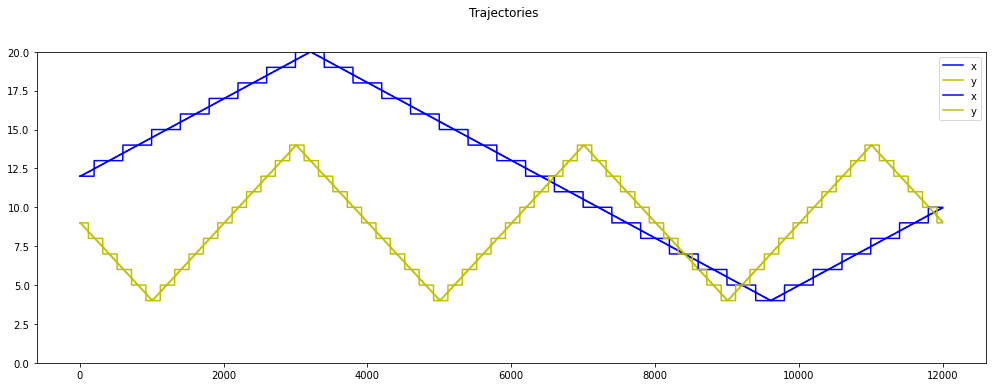

In [9]:
fig, axs = plt.subplots(1, figsize=(15,6))
fig.tight_layout(pad=5.0)
fig.suptitle("Trajectories")  
axs.plot(coor[0,:], label="x", color="b")
axs.plot(coor[1,:], label="y", color="y")
axs.plot(np.round(coor[0,:],0), label="x", color="b")
axs.plot(np.round(coor[1,:],0), label="y", color="y")
axs.set_ylim([0, 20])
plt.legend()
    